# Deep Learning-Based Groundwater Level Prediction for the Virginia Eastern Shore

## Long Short-Term Memory (LSTM) Model 

This notebook implements LSTM neural networks to predict groundwater depths
for four monitoring wells on the Virginia Eastern Shore.


### 1. IMPORTS AND SETUP

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Scikit-learn imports
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# TensorFlow/Keras imports
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
# Reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Configure plotting style
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (15, 6)
plt.rcParams['font.size'] = 12

### 2. CONFIGURATION AND DATA PATHS

In [7]:
# Project paths
BASE_DIR = Path.cwd().parent
DATA_PATH = BASE_DIR / "data" / "processed"
MODEL_PATH = BASE_DIR / "models"
RESULTS_PATH = BASE_DIR / "results"

# directories 
MODEL_PATH.mkdir(exist_ok=True)
RESULTS_PATH.mkdir(exist_ok=True)

# Version control for saving files (to avoid overwriting)
VERSION = "v2"  

# Well names
WELLS = ["withams", "greenbush", "churchneck", "capecharles"]

# Model parameters for each well
PARAMS = {
    "withams":      {"window": 60,  "units": 64,  "layers": 2, "dropout": 0.2},
    "greenbush":    {"window": 180, "units": 128, "layers": 3, "dropout": 0.3},
    "churchneck":   {"window": 60,  "units": 64,  "layers": 2, "dropout": 0.2},
    "capecharles":  {"window": 180, "units": 96,  "layers": 2, "dropout": 0.2},
}

# training parameters
EPOCHS = 120
BATCH_SIZE = 32
LEARNING_RATE = 0.001
PATIENCE = 15
TRAIN_SPLIT = 0.8
RANDOM_SEED = 42

#  random seeds for reproducibility
np.random.seed(RANDOM_SEED)
import tensorflow as tf
tf.random.set_seed(RANDOM_SEED)

### 3. UTILITY FUNCTIONS

In [9]:
def get_versioned_filename(base_name, extension, version=None):
    """Generate a versioned filename to avoid overwriting existing files."""
    if version:
        return f"{base_name}_{version}{extension}"
    else:
        return f"{base_name}{extension}"


def create_sequences(X, y, window_size):
    """Create input sequences for LSTM model."""
    X_seq, y_seq = [], []
    for i in range(len(X) - window_size):
        X_seq.append(X[i:i + window_size])
        y_seq.append(y[i + window_size])
    return np.array(X_seq), np.array(y_seq)


def calculate_metrics(y_true, y_pred):
    """Calculate comprehensive performance metrics."""
    # Calculate metrics
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    
    # Calculate normalized metrics
    data_range = np.max(y_true) - np.min(y_true)
    nrmse = rmse / data_range if data_range != 0 else np.nan
    
    # Calculate mean absolute percentage error
    mask = y_true != 0
    if np.any(mask):
        mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100
    else:
        mape = np.nan
    
    return {
        'r2': r2,
        'rmse': rmse,
        'mae': mae,
        'nrmse': nrmse,
        'mape': mape
    }


def build_lstm_model(input_shape, params):
    """Build LSTM model with specified architecture."""
    model = Sequential()
    
    for i in range(params["layers"]):
        return_sequences = (i < params["layers"] - 1)
        
        if i == 0:
            model.add(LSTM(
                params["units"], 
                return_sequences=return_sequences,
                input_shape=input_shape,
                activation='tanh',
                recurrent_activation='sigmoid'
            ))
        else:
            model.add(LSTM(
                params["units"], 
                return_sequences=return_sequences,
                activation='tanh',
                recurrent_activation='sigmoid'
            ))
        
        model.add(Dropout(params.get("dropout", 0.2)))
    
    model.add(Dense(1))
    optimizer = Adam(learning_rate=LEARNING_RATE)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    
    return model


def prepare_well_data(df, well_name, params):
    """Prepare and split data for a specific well."""
    # Extract features and target
    feature_cols = [col for col in df.columns if col not in ['date', 'gw_depth_ft']]
    X_raw = df[feature_cols].values
    y_raw = df['gw_depth_ft'].values.reshape(-1, 1)
    dates = pd.to_datetime(df['date']).values
    
    # Scale the data
    feature_scaler = MinMaxScaler()
    target_scaler = MinMaxScaler()
    
    X_scaled = feature_scaler.fit_transform(X_raw)
    y_scaled = target_scaler.fit_transform(y_raw)
    
    # Create sequences
    window = params["window"]
    X_seq, y_seq = create_sequences(X_scaled, y_scaled, window)
    
    # Split into train and test sets
    split_idx = int(TRAIN_SPLIT * len(X_seq))
    
    X_train, X_test = X_seq[:split_idx], X_seq[split_idx:]
    y_train, y_test = y_seq[:split_idx], y_seq[split_idx:]
    
    # Align dates
    dates_aligned = dates[window:]
    train_dates = dates_aligned[:split_idx]
    test_dates = dates_aligned[split_idx:]
    
    return {
        'X_train': X_train,
        'X_test': X_test,
        'y_train': y_train,
        'y_test': y_test,
        'train_dates': train_dates,
        'test_dates': test_dates,
        'feature_scaler': feature_scaler,
        'target_scaler': target_scaler,
        'feature_names': feature_cols,
        'n_features': X_scaled.shape[1]
    }

### 4. VISUALIZATION FUNCTIONS

In [10]:
# Plotting History
def plot_training_history(history, well_name, version=None):
    """Plot training and validation loss curves."""
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Loss plot
    axes[0].plot(history.history['loss'], label='Training Loss', linewidth=2)
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss (MSE)')
    axes[0].set_title(f'{well_name.upper()} - Model Training Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # MAE plot
    if 'mae' in history.history:
        axes[1].plot(history.history['mae'], label='Training MAE', linewidth=2)
        axes[1].set_xlabel('Epoch')
        axes[1].set_ylabel('Mean Absolute Error')
        axes[1].set_title(f'{well_name.upper()} - Model Training MAE')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    filename = get_versioned_filename(f'training_history_{well_name}', '.png', version)
    plt.savefig(RESULTS_PATH / filename, dpi=150, bbox_inches='tight')
    plt.show()
    print(f"    Saved: {filename}")

In [11]:
# plotting prediction
def plot_predictions(data_dict, well_name, metrics, version=None):
    """Plot actual vs predicted values with train/test split."""
    fig, ax = plt.subplots(figsize=(15, 6))
    
    # Plot training data
    ax.plot(data_dict['train_dates'], data_dict['y_train_ft'], 
            label="Training Data (Actual)", color='blue', alpha=0.5, linewidth=1)
    
    # Plot test data
    ax.plot(data_dict['test_dates'], data_dict['y_test_ft'], 
            label="Test Data (Actual)", color='black', linewidth=1.5)
    ax.plot(data_dict['test_dates'], data_dict['y_pred_ft'], 
            label="LSTM Predictions", color='red', linestyle='--', linewidth=2)
    
    # metrics annotation 
    textstr = f'R² = {metrics["r2"]:.3f}\nRMSE = {metrics["rmse"]:.3f} ft\nMAE = {metrics["mae"]:.3f} ft'
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
    ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', bbox=props)
    
    ax.set_title(f"LSTM Groundwater Depth Predictions: {well_name.upper()} Well")
    ax.set_xlabel("Date")
    ax.set_ylabel("Groundwater Depth (ft)")
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)
    
    # Format x-axis dates
    ax.xaxis.set_major_locator(mdates.YearLocator(2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.set_xlim(pd.Timestamp('2007-06-01'), pd.Timestamp('2026-06-01'))
    
    plt.tight_layout()
    filename = get_versioned_filename(f'predictions_{well_name}', '.png', version)
    plt.savefig(RESULTS_PATH / filename, dpi=150, bbox_inches='tight')
    plt.show()
    print(f"    Saved: {filename}")

In [12]:
# plotting comparison function
def plot_scatter_comparison(data_dict, well_name, metrics, version=None):
    """Create scatter plot of actual vs predicted values."""
    fig, ax = plt.subplots(figsize=(8, 8))
    
    # Scatter plot
    ax.scatter(data_dict['y_test_ft'], data_dict['y_pred_ft'], 
               alpha=0.6, c='steelblue', edgecolors='white', linewidth=0.5)
    
    # Perfect prediction line
    min_val = min(data_dict['y_test_ft'].min(), data_dict['y_pred_ft'].min())
    max_val = max(data_dict['y_test_ft'].max(), data_dict['y_pred_ft'].max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
    
    ax.set_xlabel('Actual Groundwater Depth (ft)')
    ax.set_ylabel('Predicted Groundwater Depth (ft)')
    ax.set_title(f'{well_name.upper()} Well: Actual vs Predicted')
    
    # metrics annotation 
    textstr = f'R² = {metrics["r2"]:.3f}\nRMSE = {metrics["rmse"]:.3f} ft'
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', bbox=props)
    
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_aspect('equal')
    
    plt.tight_layout()
    filename = get_versioned_filename(f'scatter_{well_name}', '.png', version)
    plt.savefig(RESULTS_PATH / filename, dpi=150, bbox_inches='tight')
    plt.show()
    print(f"    Saved: {filename}")

In [13]:
# plotting residual function
def plot_residuals(data_dict, well_name, metrics, version=None):
    """Plot residuals (errors) over time."""
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Calculate residuals
    residuals = data_dict['y_test_ft'].flatten() - data_dict['y_pred_ft'].flatten()
    
    # Residuals over time
    axes[0].scatter(data_dict['test_dates'], residuals, alpha=0.6, c='steelblue', s=20)
    axes[0].axhline(y=0, color='r', linestyle='--', linewidth=2)
    axes[0].set_xlabel('Date')
    axes[0].set_ylabel('Residual (ft)')
    axes[0].set_title(f'{well_name.upper()} - Residuals Over Time')
    axes[0].grid(True, alpha=0.3)
    axes[0].xaxis.set_major_locator(mdates.YearLocator(2))
    axes[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    
    # Residuals distribution
    axes[1].hist(residuals, bins=30, edgecolor='black', alpha=0.7, color='steelblue')
    axes[1].axvline(x=0, color='r', linestyle='--', linewidth=2)
    axes[1].set_xlabel('Residual (ft)')
    axes[1].set_ylabel('Frequency')
    axes[1].set_title(f'{well_name.upper()} - Residual Distribution')
    axes[1].grid(True, alpha=0.3)
    
    # Add statistics
    mean_res = np.mean(residuals)
    std_res = np.std(residuals)
    textstr = f'Mean: {mean_res:.3f} ft\nStd: {std_res:.3f} ft'
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
    axes[1].text(0.95, 0.95, textstr, transform=axes[1].transAxes, fontsize=10,
                verticalalignment='top', horizontalalignment='right', bbox=props)
    
    plt.tight_layout()
    filename = get_versioned_filename(f'residuals_{well_name}', '.png', version)
    plt.savefig(RESULTS_PATH / filename, dpi=150, bbox_inches='tight')
    plt.show()
    print(f"    Saved: {filename}")

In [14]:
# plotting comparison heatmap function
def plot_comparison_heatmap(results_df, version=None):
    """Create a heatmap comparing performance across wells."""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Prepare data for heatmap
    metrics_to_plot = ['r2', 'rmse', 'mae', 'nrmse']
    wells = results_df['Well Name'].values
    
    # Create data matrix
    data_matrix = results_df[metrics_to_plot].values.T
    
    # First heatmap
    im1 = axes[0].imshow(data_matrix, cmap='YlOrRd', aspect='auto')
    axes[0].set_xticks(range(len(wells)))
    axes[0].set_yticks(range(len(metrics_to_plot)))
    axes[0].set_xticklabels(wells, rotation=45, ha='right')
    axes[0].set_yticklabels(['R²', 'RMSE', 'MAE', 'NRMSE'])
    axes[0].set_title('Model Performance Metrics by Well')
    
    # Add text annotations
    for i in range(len(metrics_to_plot)):
        for j in range(len(wells)):
            text = axes[0].text(j, i, f'{data_matrix[i, j]:.3f}',
                               ha="center", va="center", color="black", fontsize=9)
    
    plt.colorbar(im1, ax=axes[0])
    
    # Second plot - Bar chart
    x = np.arange(len(wells))
    width = 0.35
    
    ax2 = axes[1]
    bars1 = ax2.bar(x - width/2, results_df['r2'], width, label='R²', color='steelblue')
    ax3 = ax2.twinx()
    bars2 = ax3.bar(x + width/2, results_df['rmse'], width, label='RMSE (ft)', color='coral')
    
    ax2.set_xlabel('Well Name')
    ax2.set_ylabel('R² Score', color='steelblue')
    ax3.set_ylabel('RMSE (ft)', color='coral')
    ax2.set_xticks(x)
    ax2.set_xticklabels(wells, rotation=45, ha='right')
    ax2.set_title('R² and RMSE Comparison Across Wells')
    
    # Add value labels
    for bar in bars1:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9)
    
    for bar in bars2:
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9, color='coral')
    
    plt.tight_layout()
    filename = get_versioned_filename('performance_heatmap', '.png', version)
    plt.savefig(RESULTS_PATH / filename, dpi=150, bbox_inches='tight')
    plt.show()
    print(f"    Saved: {filename}")

In [15]:
# plotting comparison for all 4 wells function
def plot_all_wells_comparison(all_predictions, version=None):
    """Plot predictions for all wells in a single figure for comparison."""
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()
    
    for idx, (well_name, data) in enumerate(all_predictions.items()):
        ax = axes[idx]
        
        ax.plot(data['test_dates'], data['y_test_ft'], 
                label='Actual', color='black', linewidth=1.5)
        ax.plot(data['test_dates'], data['y_pred_ft'], 
                label='LSTM Prediction', color='red', linestyle='--', linewidth=2)
        
        ax.set_title(f'{well_name.upper()} Well')
        ax.set_xlabel('Date')
        ax.set_ylabel('Depth (ft)')
        ax.legend(loc='upper right', fontsize=9)
        ax.grid(True, alpha=0.3)
        ax.xaxis.set_major_locator(mdates.YearLocator(3))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
        ax.set_xlim(pd.Timestamp('2007'), pd.Timestamp('2026'))
        
        # Add metrics text - USING LOWERCASE KEYS
        metrics = data['metrics']
        textstr = f'R² = {metrics["r2"]:.3f}\nRMSE = {metrics["rmse"]:.3f} ft'
        ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=9,
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    plt.suptitle('LSTM Model Predictions for All Wells', fontsize=16, y=1.02)
    plt.tight_layout()
    filename = get_versioned_filename('all_wells_comparison', '.png', version)
    plt.savefig(RESULTS_PATH / filename, dpi=150, bbox_inches='tight')
    plt.show()
    print(f"    Saved: {filename}")

In [16]:
# save prediction output file
def save_predictions_to_csv(all_predictions, version=None):
    """Save prediction results to CSV files with versioning."""
    print(f"\n    Saving prediction CSVs...")
    
    for well_name, data in all_predictions.items():
        df_pred = pd.DataFrame({
            'Date': data['test_dates'],
            'Actual_GWL_ft': data['y_test_ft'],
            'Predicted_GWL_ft': data['y_pred_ft'],
            'Residual_ft': data['y_test_ft'] - data['y_pred_ft']
        })
        
        filename = get_versioned_filename(f"LSTM_predictions_{well_name}", ".csv", version)
        filepath = RESULTS_PATH / filename
        df_pred.to_csv(filepath, index=False)
        print(f"      - {filename}")

### 5. MODEL TRAINING AND EVALUATION

In [17]:
def train_and_evaluate_well(well_name, params, version=None):
    """Train LSTM model for a specific well and evaluate performance."""
    print(f"\n{'='*60}")
    print(f"Training LSTM model for {well_name.upper()} well...")
    print(f"Window size: {params['window']}, Units: {params['units']}, Layers: {params['layers']}")
    print(f"{'='*60}")
    
    # Load and prepare data
    df = pd.read_csv(DATA_PATH / f"gw_{well_name}_l.csv")
    data = prepare_well_data(df, well_name, params)
    
    # Build model
    input_shape = (data['X_train'].shape[1], data['X_train'].shape[2])
    model = build_lstm_model(input_shape, params)
    print(f"Model built with input shape: {input_shape}")
    
    # Callbacks
    callbacks = [
        EarlyStopping(monitor='loss', patience=PATIENCE, restore_best_weights=True, verbose=1),
        ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)
    ]
    
    # Train model
    history = model.fit(
        data['X_train'], data['y_train'],
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=callbacks,
        verbose=0
    )
    
    # Make predictions
    y_pred_scaled = model.predict(data['X_test'], verbose=0)
    
    # Inverse transform to get actual values
    y_train_ft = data['target_scaler'].inverse_transform(data['y_train'])
    y_test_ft = data['target_scaler'].inverse_transform(data['y_test'])
    y_pred_ft = data['target_scaler'].inverse_transform(y_pred_scaled)
    
    # Calculate metrics
    metrics = calculate_metrics(y_test_ft, y_pred_ft)
    
    # Add to data dictionary
    data['y_train_ft'] = y_train_ft
    data['y_test_ft'] = y_test_ft
    data['y_pred_ft'] = y_pred_ft
    
    # Print results - USING LOWERCASE KEYS
    print(f"\n Model training completed!")
    print(f"   Final Metrics:")
    print(f"   - R² Score:  {metrics['r2']:.4f}")
    print(f"   - RMSE:      {metrics['rmse']:.4f} ft")
    print(f"   - MAE:       {metrics['mae']:.4f} ft")
    print(f"   - NRMSE:     {metrics['nrmse']:.4f}")
    print(f"   - MAPE:      {metrics['mape']:.2f}%")
    
    return metrics, data, history, model

### 6. MAIN EXECUTION

In [18]:
print("\n" + "="*80)
print("DEEP LEARNING-BASED GROUNDWATER LEVEL PREDICTION")
print("LSTM MODEL IMPLEMENTATION - VERSION 2")
print("="*80)
print(f"\n Using version tag: '{VERSION}' for all saved files")

# Store results
all_results = []
all_data = {}
all_histories = {}
all_models = {}
all_predictions = {}

# Train models for each well
for well in WELLS:
    metrics, data, history, model = train_and_evaluate_well(well, PARAMS[well], VERSION)
    
    # Store results with LOWERCASE keys for consistency
    all_results.append({
        'Well Name': well,
        'r2': metrics['r2'],
        'rmse': metrics['rmse'],
        'mae': metrics['mae'],
        'nrmse': metrics['nrmse'],
        'mape': metrics['mape']
    })
    
    all_data[well] = data
    all_histories[well] = history
    all_models[well] = model
    all_predictions[well] = {
        'test_dates': data['test_dates'],
        'y_test_ft': data['y_test_ft'].flatten(),
        'y_pred_ft': data['y_pred_ft'].flatten(),
        'metrics': metrics  # This already has lowercase keys
    }
    
    # Save model with version
    model_filename = get_versioned_filename(f"LSTM_{well}", ".h5", VERSION)
    model_path = MODEL_PATH / model_filename
    model.save(model_path)
    print(f"    Model saved to: {model_path}")


DEEP LEARNING-BASED GROUNDWATER LEVEL PREDICTION
LSTM MODEL IMPLEMENTATION - VERSION 2

 Using version tag: 'v2' for all saved files

Training LSTM model for WITHAMS well...
Window size: 60, Units: 64, Layers: 2
Model built with input shape: (60, 12)

Epoch 31: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 37: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 47: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 52: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 57: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 62: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.

Epoch 67: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.

Epoch 72: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.

Epoch 77: ReduceLROnPlateau reducing learning rate to 1.9531250927684596e-06.

Epoch 82: ReduceLROnPlateau reducing learnin


 Model training completed!
   Final Metrics:
   - R² Score:  0.9912
   - RMSE:      0.0661 ft
   - MAE:       0.0422 ft
   - NRMSE:     0.0183
   - MAPE:      0.46%
   💾 Model saved to: C:\DTSC691Project\Groundwater_ML\models\LSTM_withams_v2.h5

Training LSTM model for GREENBUSH well...
Window size: 180, Units: 128, Layers: 3
Model built with input shape: (180, 12)

Epoch 60: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 68: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 74: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 80: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 90: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 95: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.

Epoch 100: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.

Epoch 105: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.

Epoc


 Model training completed!
   Final Metrics:
   - R² Score:  0.8099
   - RMSE:      1.6891 ft
   - MAE:       1.2134 ft
   - NRMSE:     0.0747
   - MAPE:      1.25%
   💾 Model saved to: C:\DTSC691Project\Groundwater_ML\models\LSTM_greenbush_v2.h5

Training LSTM model for CHURCHNECK well...
Window size: 60, Units: 64, Layers: 2
Model built with input shape: (60, 12)

Epoch 39: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 45: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 54: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 59: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 64: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 73: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.

Epoch 78: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.

Epoch 83: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.

Epoch 


 Model training completed!
   Final Metrics:
   - R² Score:  0.9823
   - RMSE:      0.1369 ft
   - MAE:       0.0860 ft
   - NRMSE:     0.0225
   - MAPE:      1.22%
   💾 Model saved to: C:\DTSC691Project\Groundwater_ML\models\LSTM_churchneck_v2.h5

Training LSTM model for CAPECHARLES well...
Window size: 180, Units: 96, Layers: 2
Model built with input shape: (180, 12)

Epoch 26: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 32: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 39: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 44: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 49: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 54: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.

Epoch 59: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.

Epoch 64: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.
Epo


 Model training completed!
   Final Metrics:
   - R² Score:  0.9942
   - RMSE:      0.0690 ft
   - MAE:       0.0535 ft
   - NRMSE:     0.0184
   - MAPE:      0.49%
   💾 Model saved to: C:\DTSC691Project\Groundwater_ML\models\LSTM_capecharles_v2.h5


### 7. VISUALIZATION


GENERATING VISUALIZATIONS...

 Generating plots for WITHAMS well...


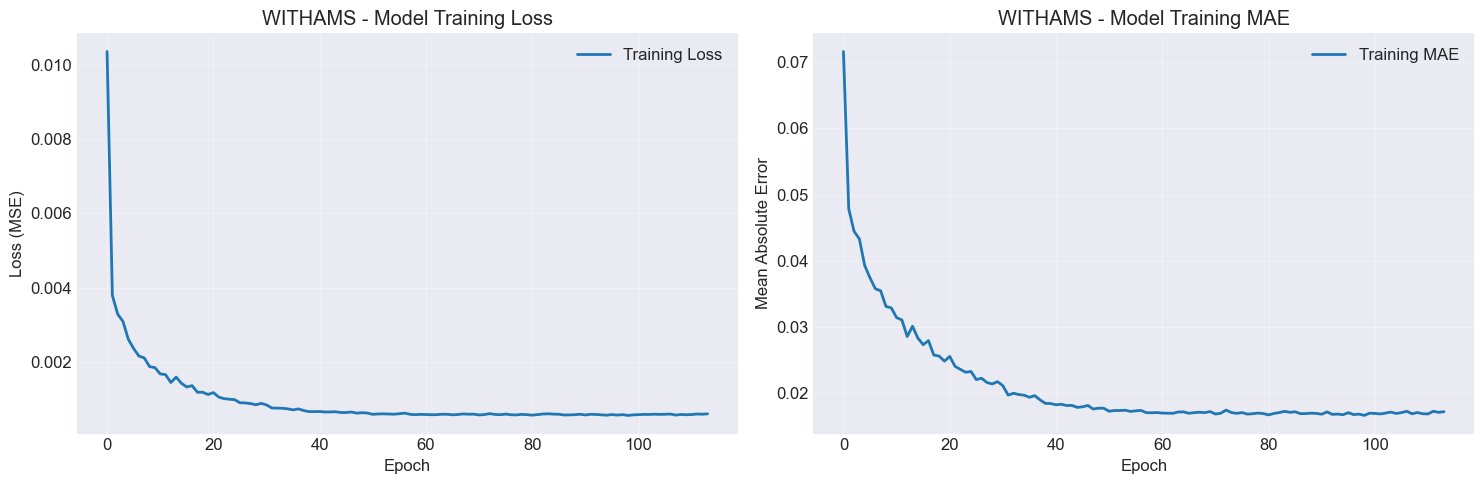

    Saved: training_history_withams_v2.png

 Generating plots for GREENBUSH well...


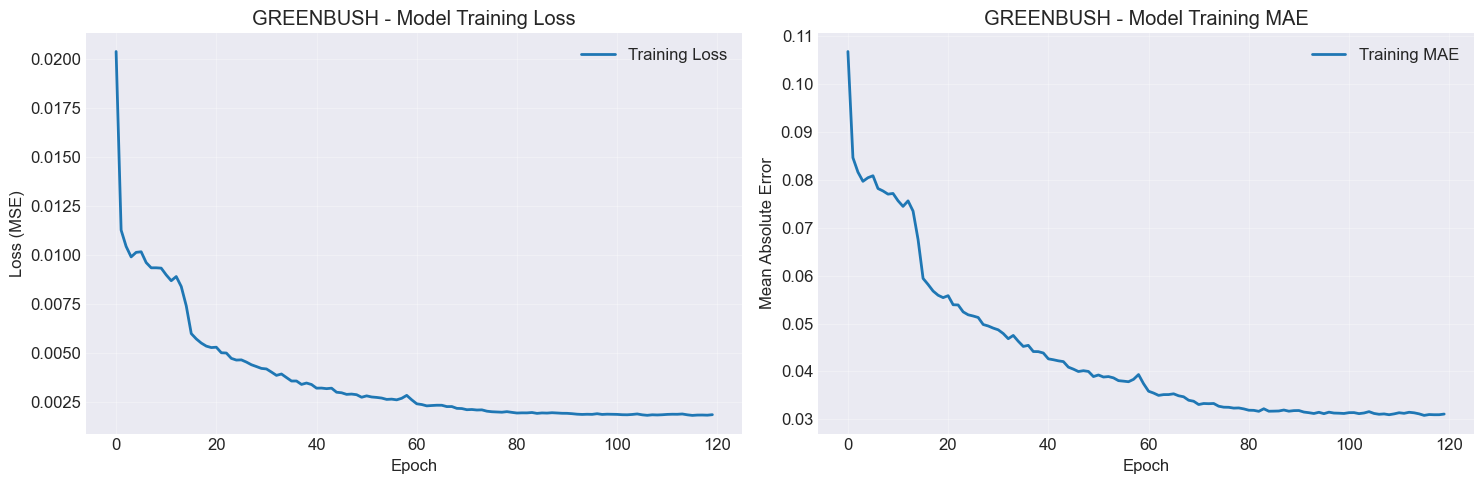

    Saved: training_history_greenbush_v2.png

 Generating plots for CHURCHNECK well...


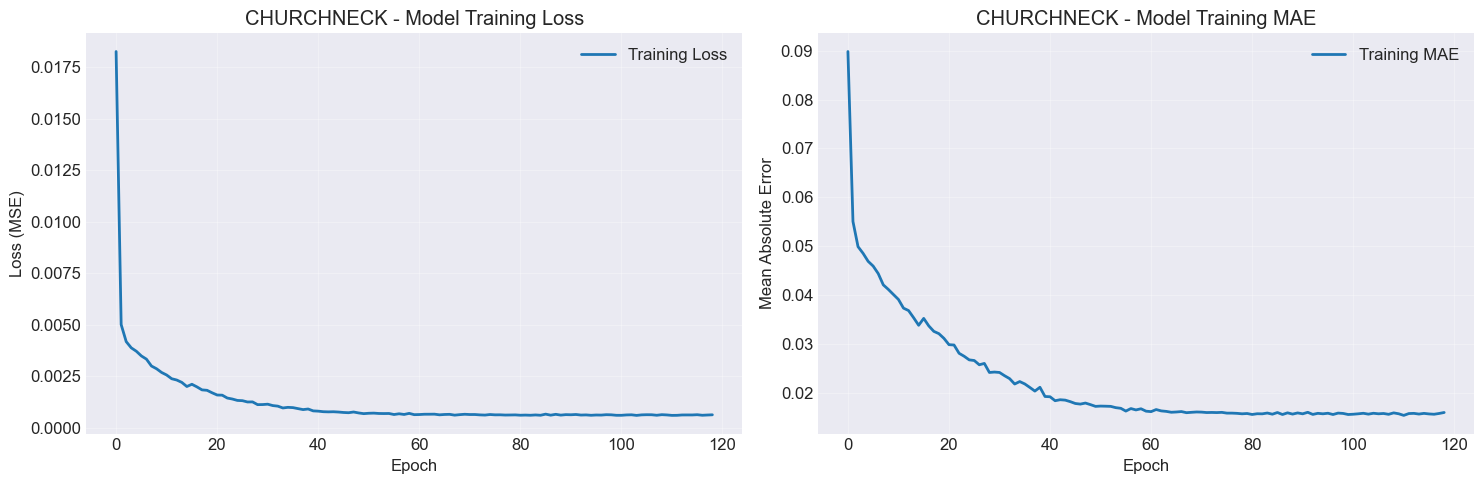

    Saved: training_history_churchneck_v2.png

 Generating plots for CAPECHARLES well...


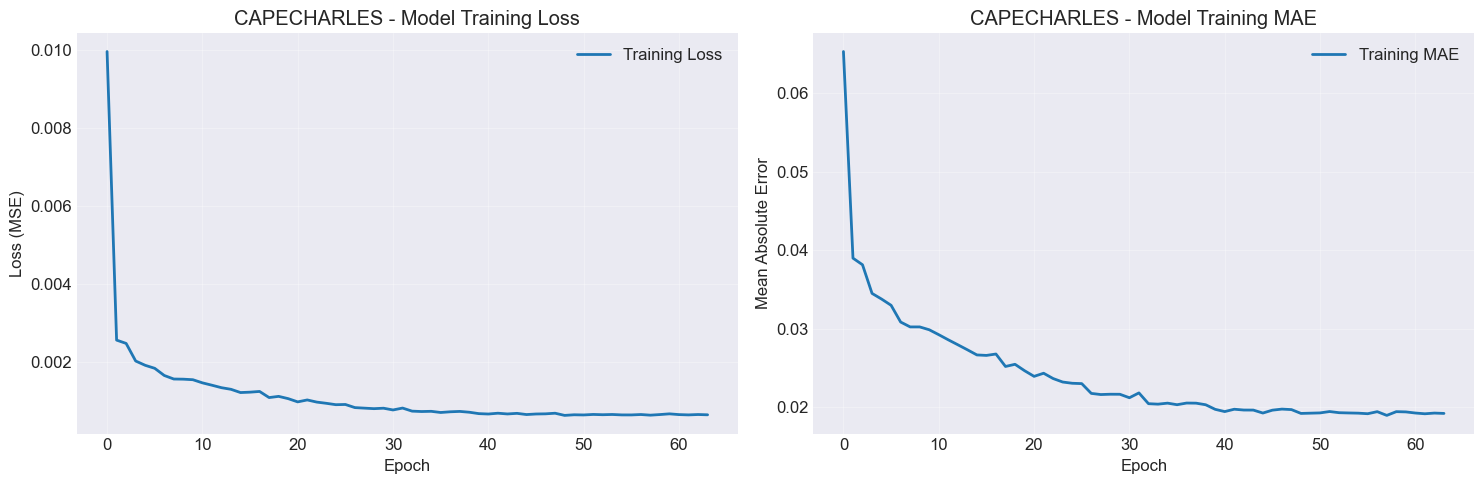

    Saved: training_history_capecharles_v2.png


In [21]:
print("\n" + "="*60)
print("GENERATING VISUALIZATIONS...")
print("="*60)

# Generate plots for each well
for well in WELLS:
    print(f"\n Generating plots for {well.upper()} well...")
    
    data = all_data[well]
    history = all_histories[well]
    metrics = all_predictions[well]['metrics']  # Get metrics with lowercase keys
    
    # Plot training history
    plot_training_history(history, well, VERSION)
  


 Generating plots for WITHAMS well...


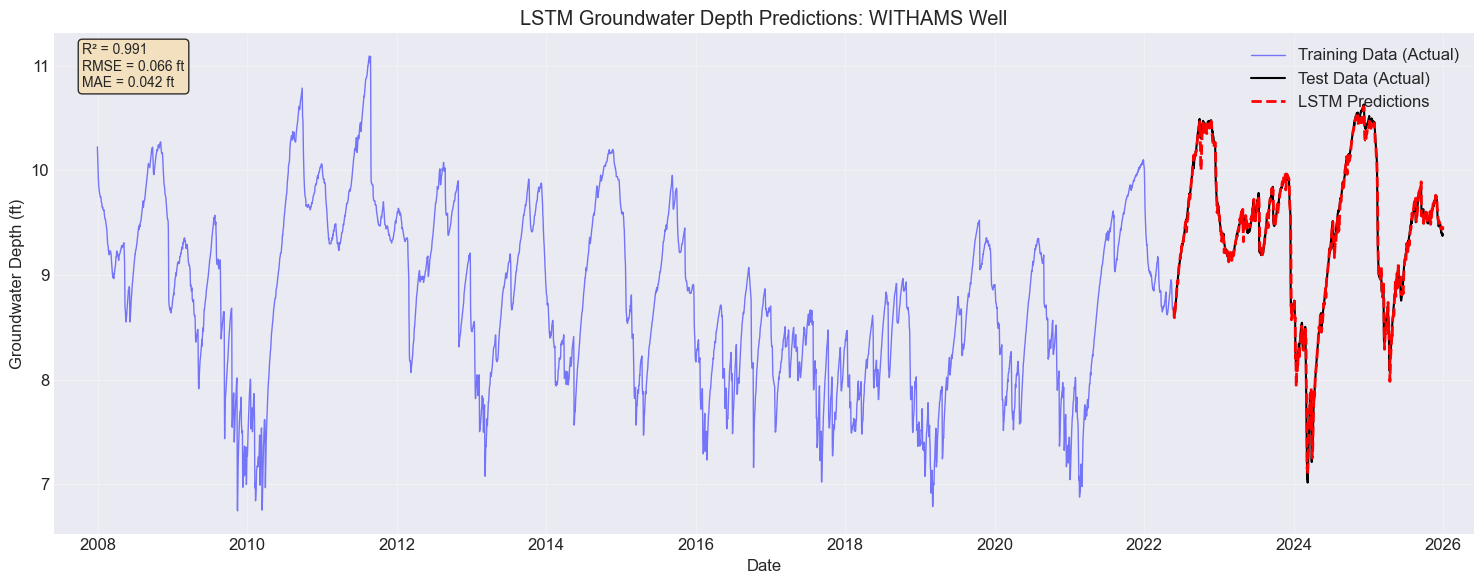

    Saved: predictions_withams_v2.png

 Generating plots for GREENBUSH well...


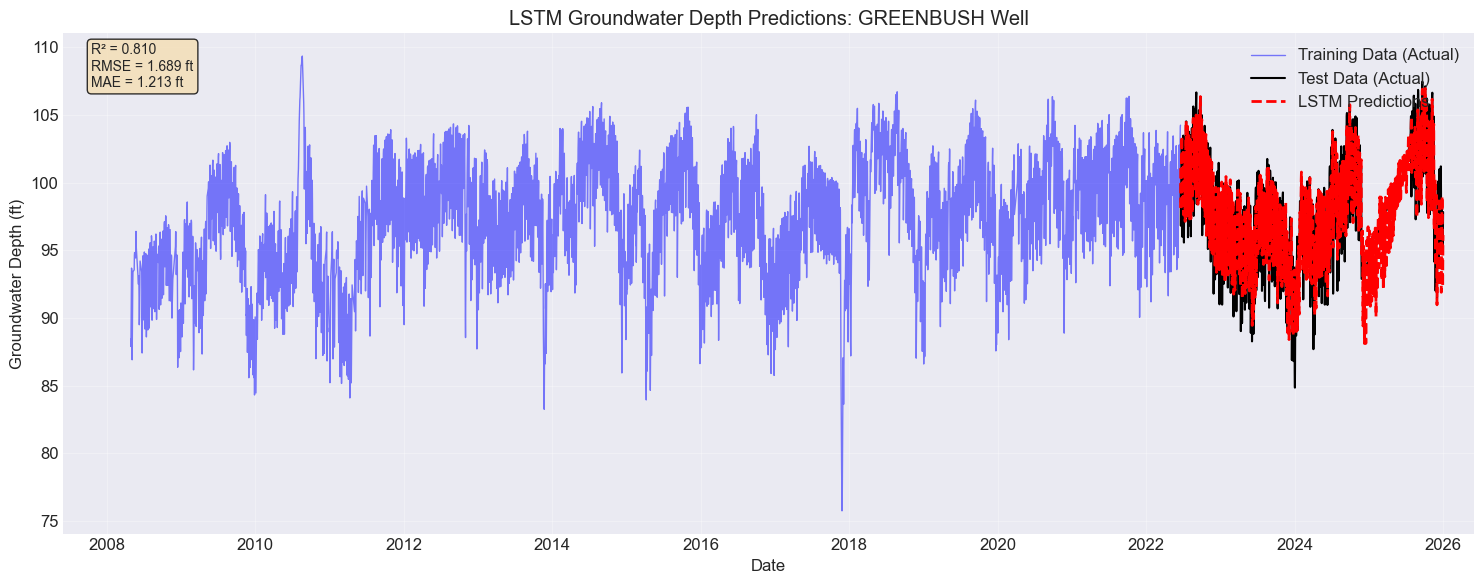

    Saved: predictions_greenbush_v2.png

 Generating plots for CHURCHNECK well...


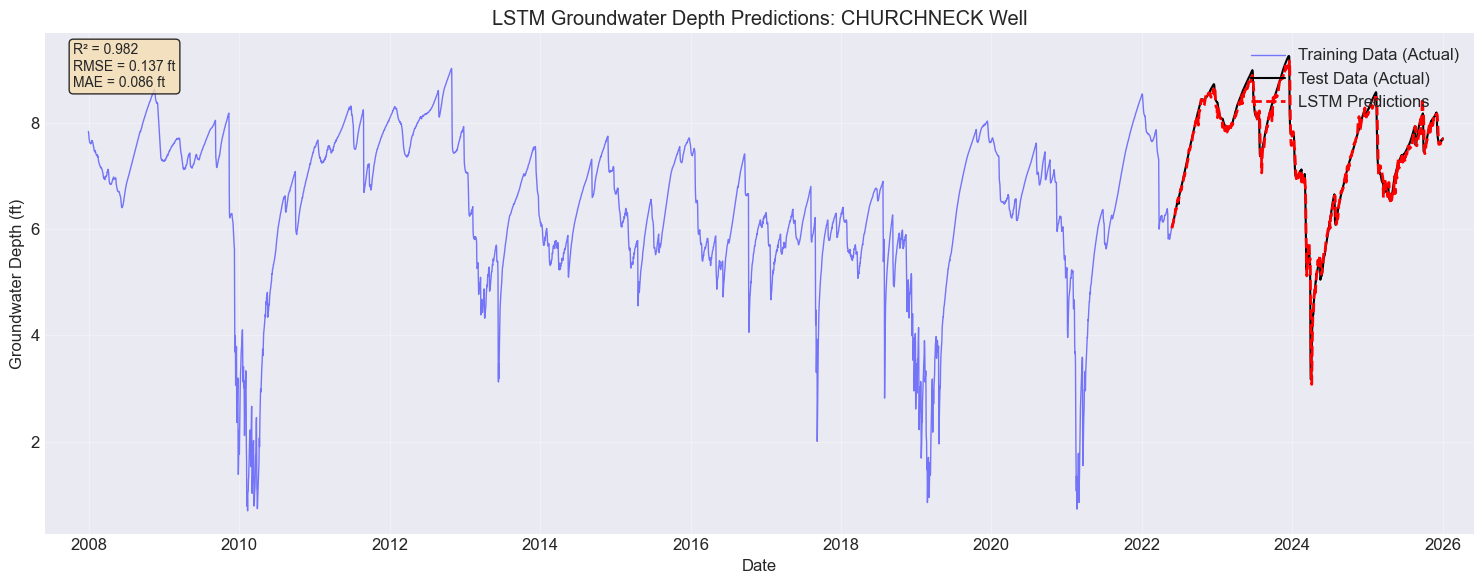

    Saved: predictions_churchneck_v2.png

 Generating plots for CAPECHARLES well...


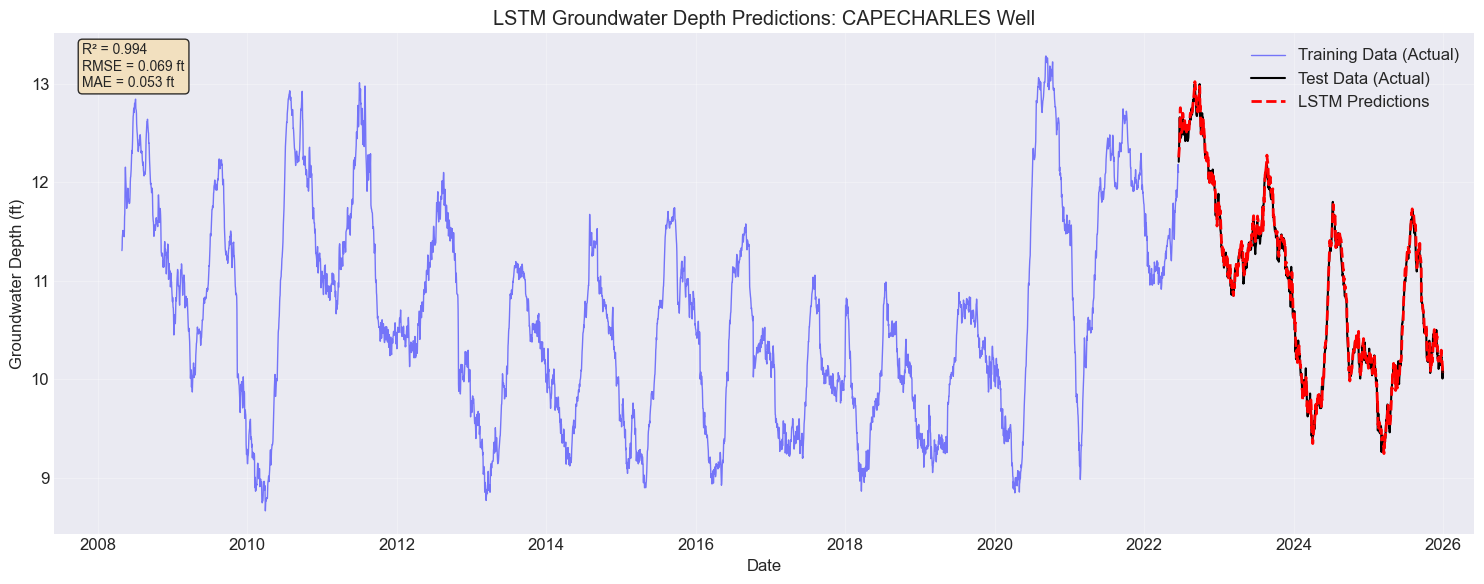

    Saved: predictions_capecharles_v2.png


In [31]:
# Generate plots for each well
for well in WELLS:
    print(f"\n Generating plots for {well.upper()} well...")
    
    data = all_data[well]
    history = all_histories[well]
    metrics = all_predictions[well]['metrics']  # Get metrics with lowercase keys  
    # Plot predictions
    plot_predictions(data, well, metrics, VERSION)
  


 Generating plots for WITHAMS well...


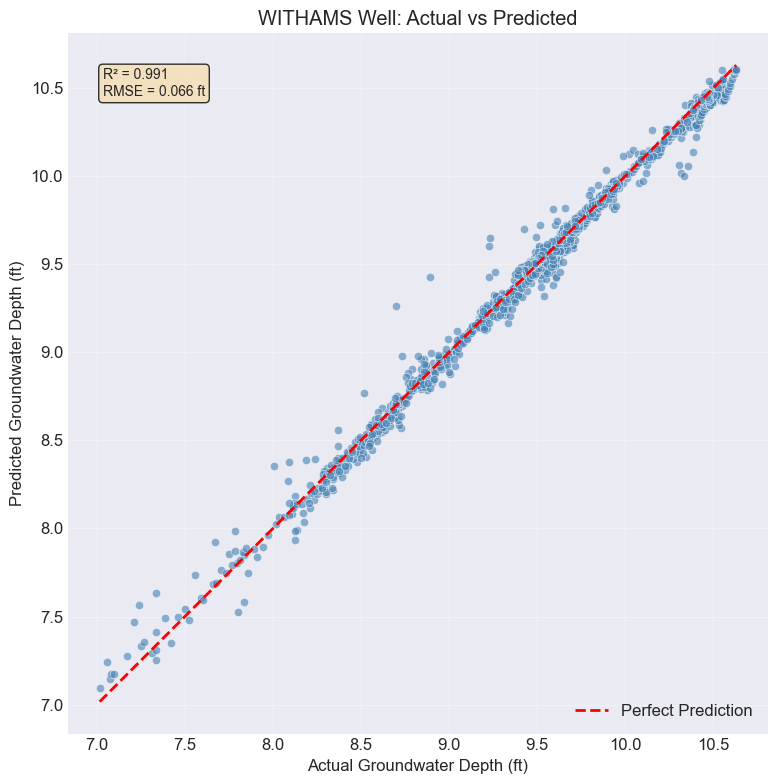

    Saved: scatter_withams_v2.png

 Generating plots for GREENBUSH well...


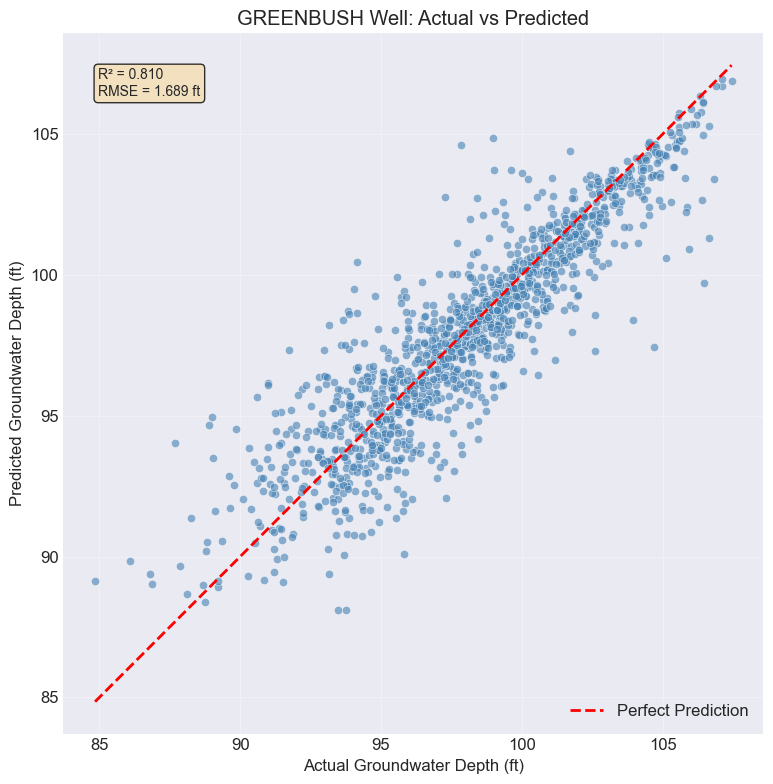

    Saved: scatter_greenbush_v2.png

 Generating plots for CHURCHNECK well...


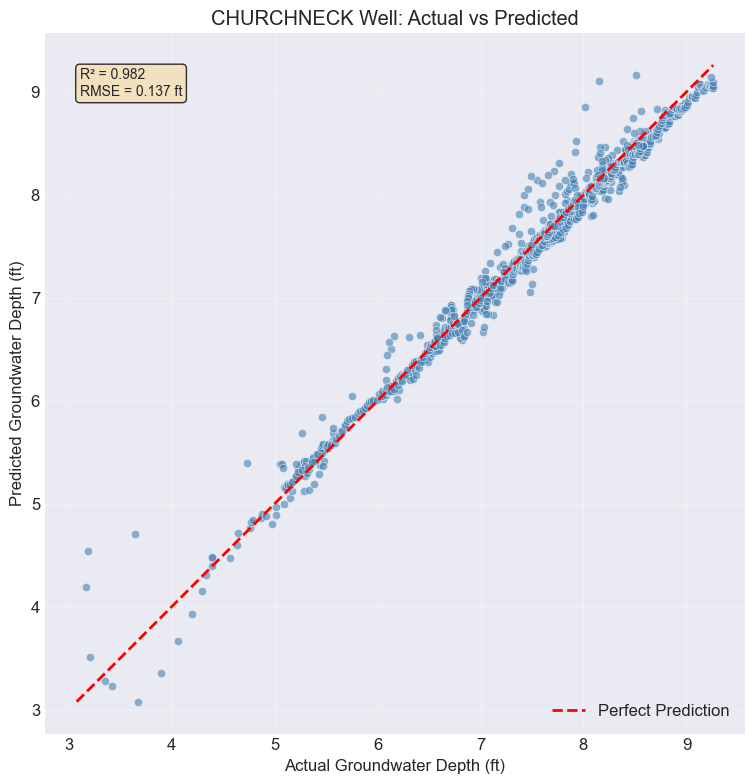

    Saved: scatter_churchneck_v2.png

 Generating plots for CAPECHARLES well...


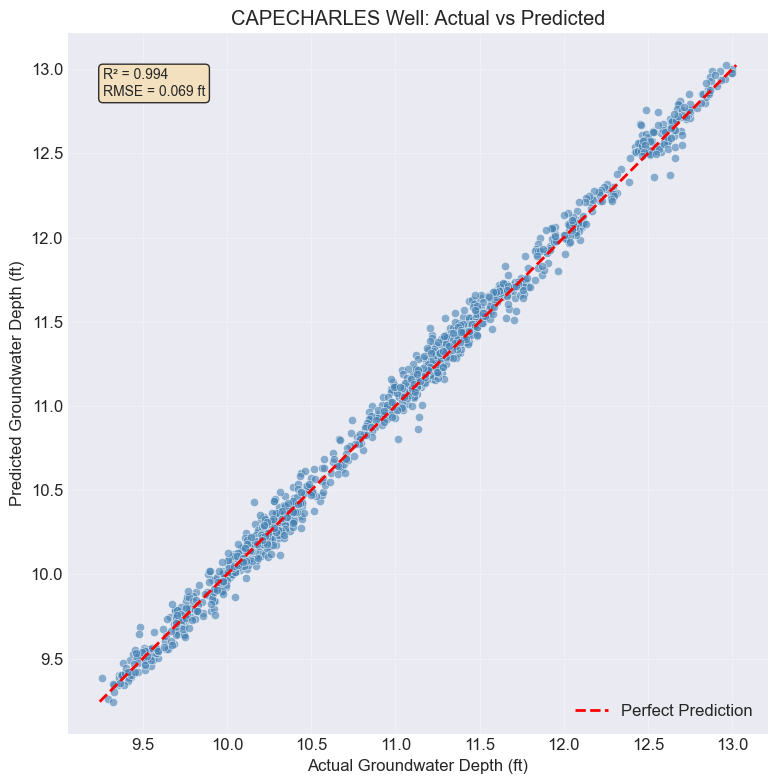

    Saved: scatter_capecharles_v2.png


In [29]:
# Generate plots for each well
for well in WELLS:
    print(f"\n Generating plots for {well.upper()} well...")
    
    data = all_data[well]
    history = all_histories[well]
    metrics = all_predictions[well]['metrics']  # Get metrics with lowercase keys  
    # Plot scatter comparison
    plot_scatter_comparison(data, well, metrics, VERSION)


 Generating plots for WITHAMS well...


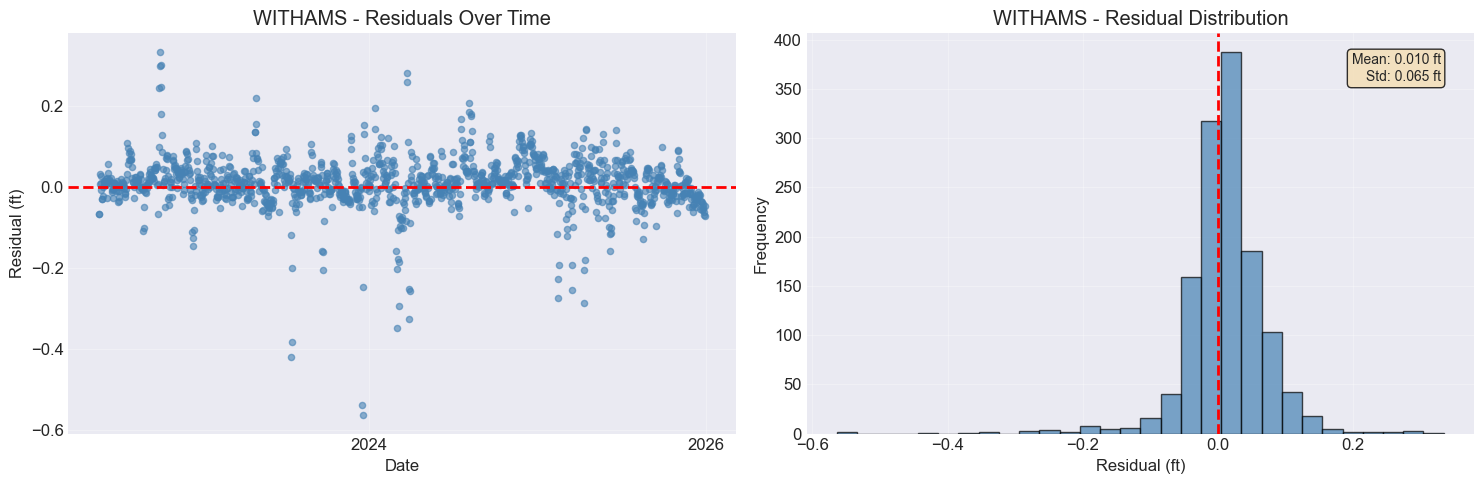

    Saved: residuals_withams_v2.png

 Generating plots for GREENBUSH well...


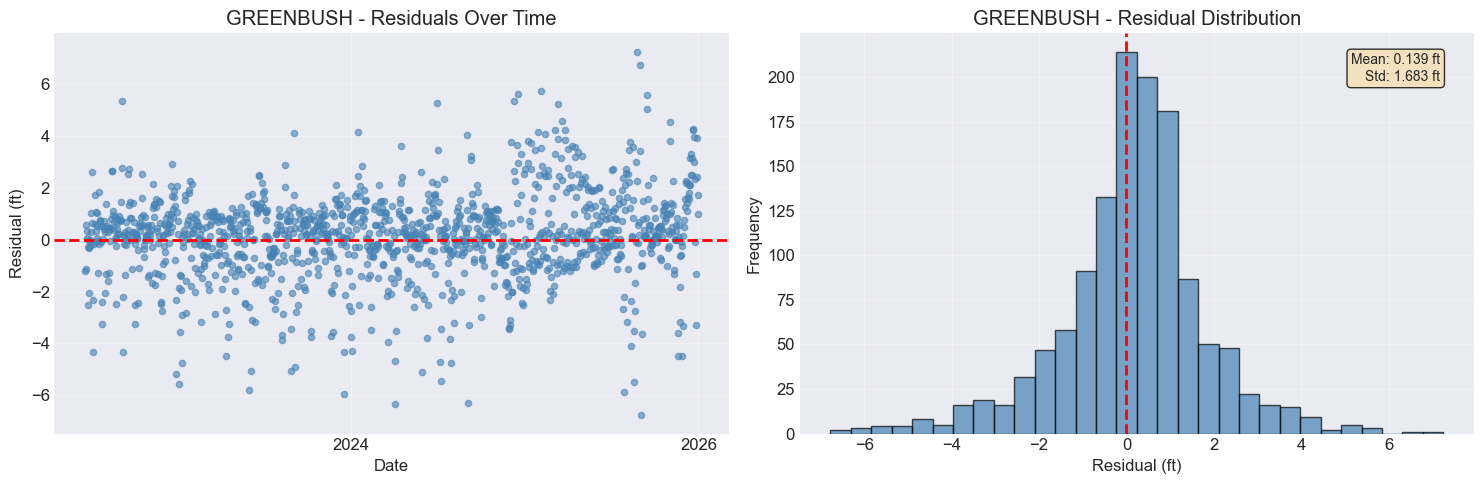

    Saved: residuals_greenbush_v2.png

 Generating plots for CHURCHNECK well...


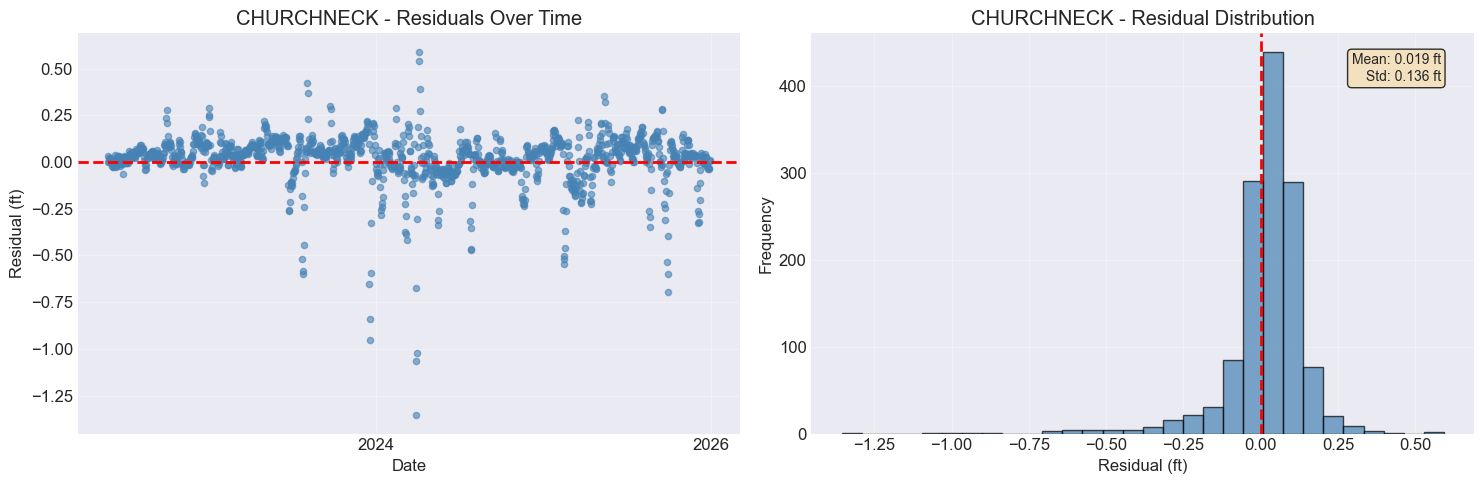

    Saved: residuals_churchneck_v2.png

 Generating plots for CAPECHARLES well...


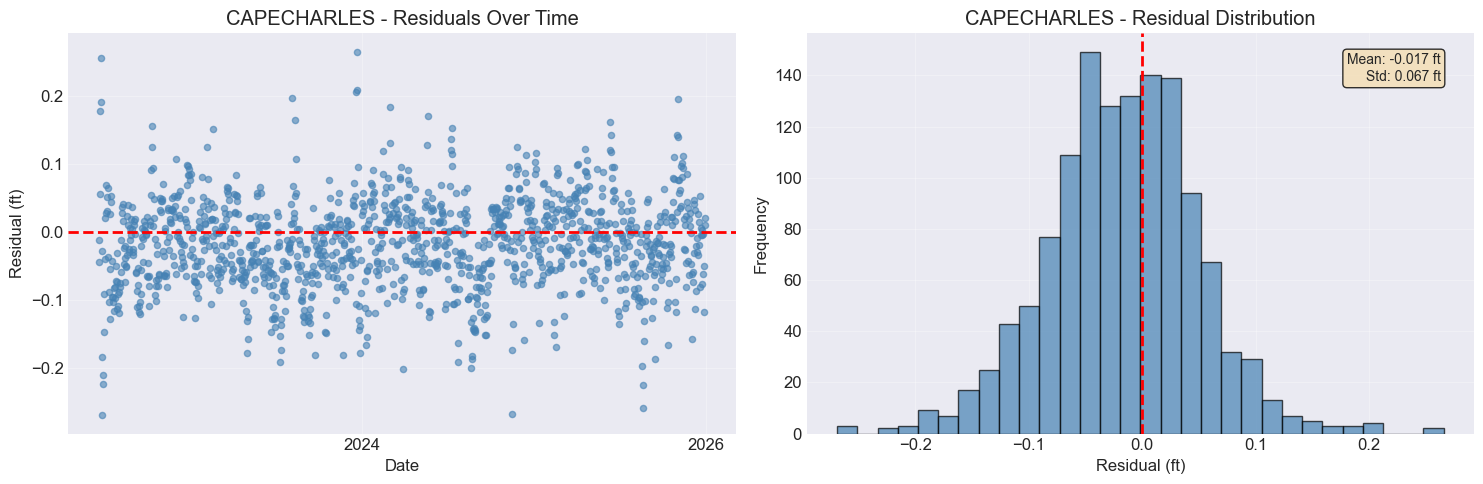

    Saved: residuals_capecharles_v2.png


In [26]:
for well in WELLS:
    print(f"\n Generating plots for {well.upper()} well...")
    
    data = all_data[well]
    history = all_histories[well]
    metrics = all_predictions[well]['metrics']  # Get metrics with lowercase keys    
    # Plot residuals
    plot_residuals(data, well, metrics, VERSION)

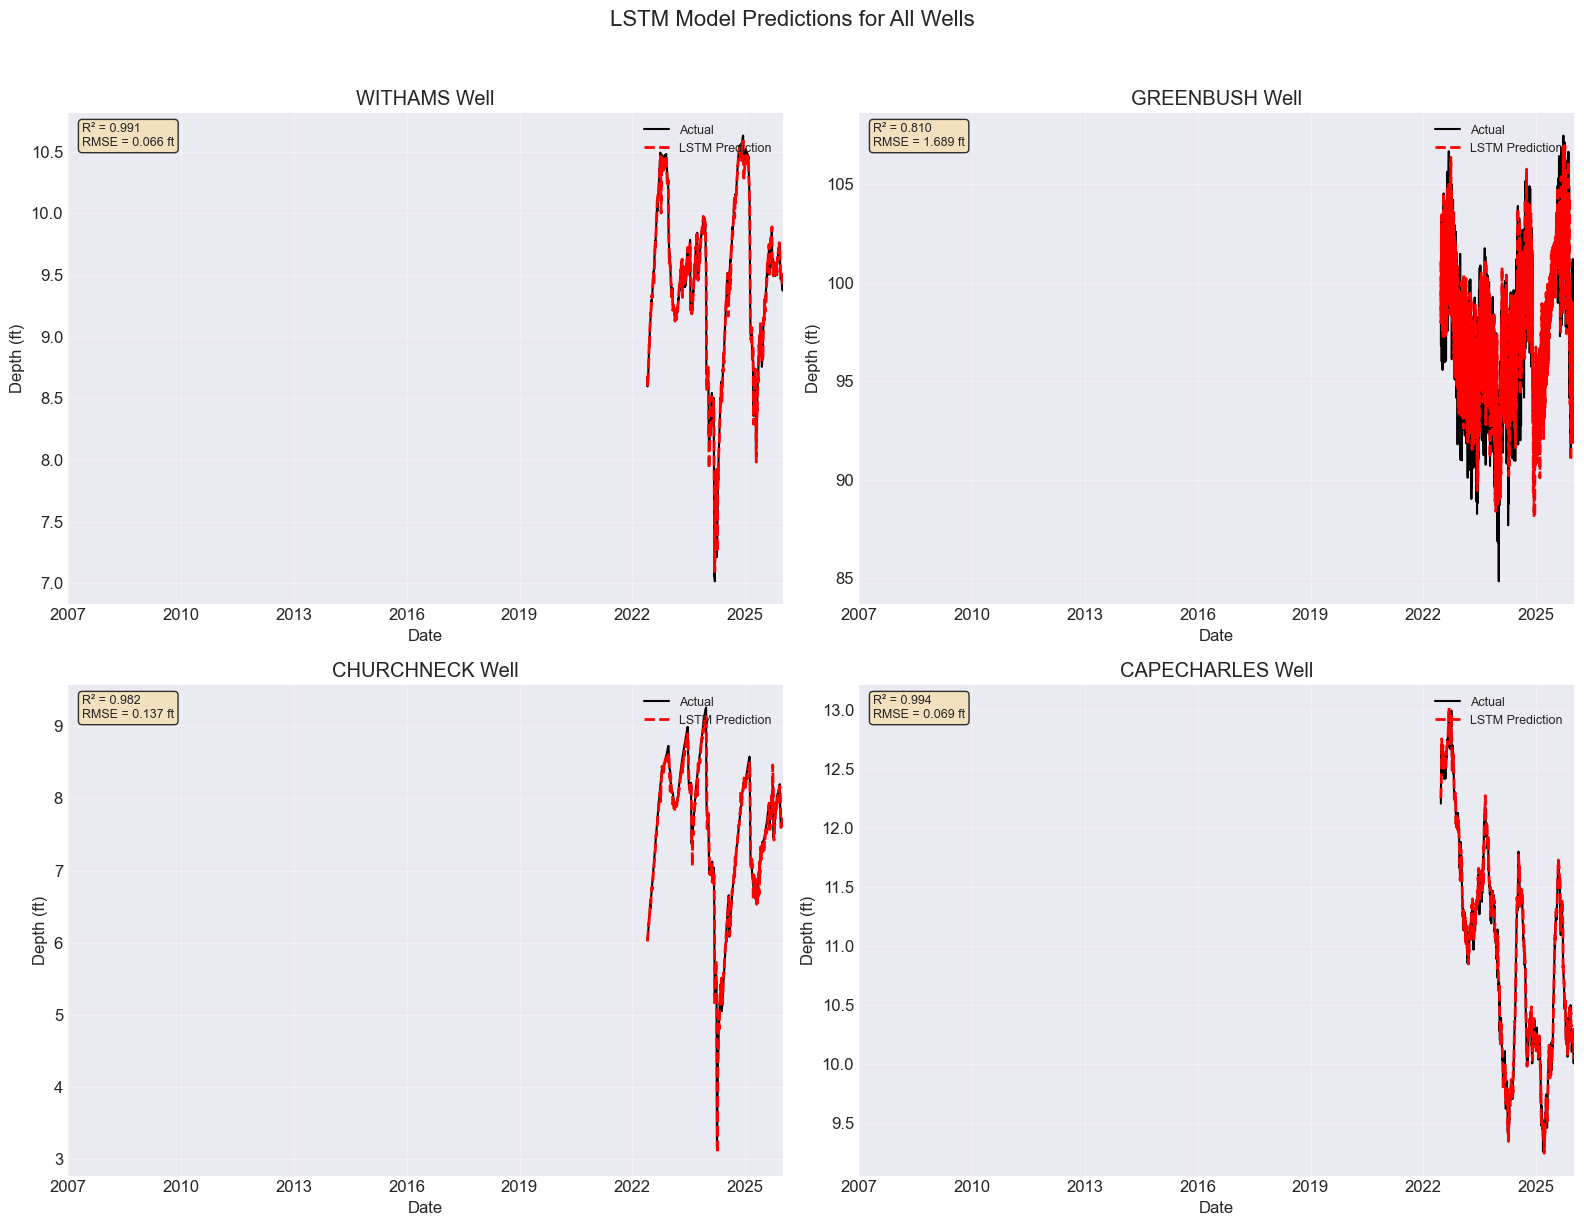

    Saved: all_wells_comparison_v2.png


In [27]:
# Create results dataframe
results_df = pd.DataFrame(all_results)
results_df = results_df.sort_values('r2', ascending=False).reset_index(drop=True)

# Plot comparison across all wells
plot_all_wells_comparison(all_predictions, VERSION)

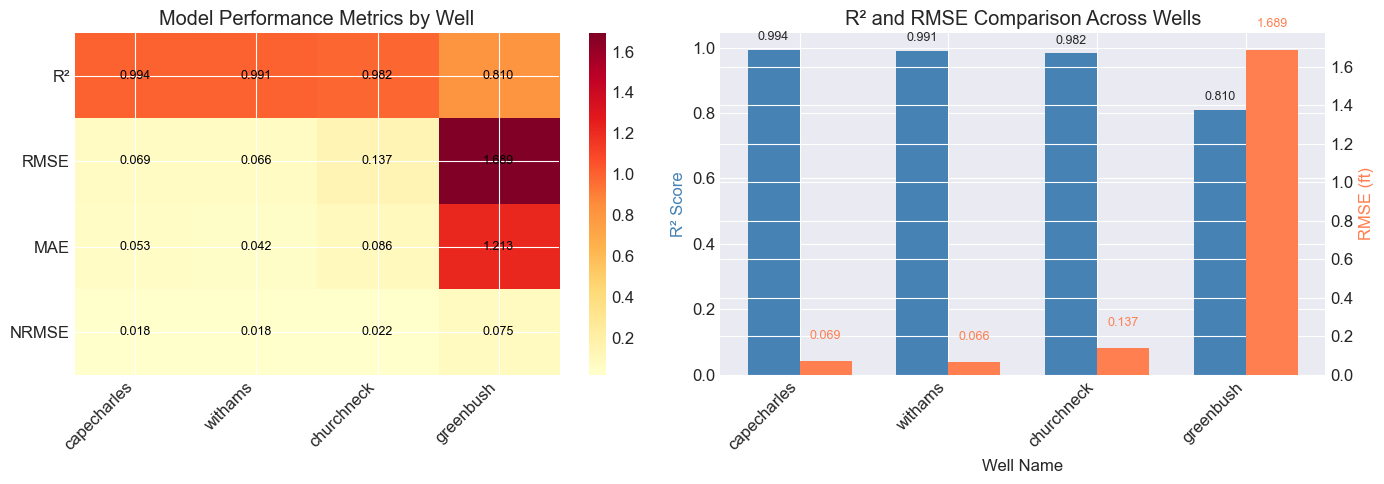

    Saved: performance_heatmap_v2.png

    Saving prediction CSVs...
      - LSTM_predictions_withams_v2.csv
      - LSTM_predictions_greenbush_v2.csv
      - LSTM_predictions_churchneck_v2.csv
      - LSTM_predictions_capecharles_v2.csv


In [28]:
# Plot performance heatmap
plot_comparison_heatmap(results_df, VERSION)

# Save predictions to CSV
save_predictions_to_csv(all_predictions, VERSION)

### 8. RESULTS SUMMARY

In [20]:
print("\n" + "="*60)
print("MODEL PERFORMANCE SUMMARY")
print("="*60)

# Display results table - NOW USING LOWERCASE KEYS CONSISTENTLY
print("\n Performance Metrics Summary:")
print("-"*80)
print(f"{'Well Name':<15} {'R²':<10} {'RMSE (ft)':<12} {'MAE (ft)':<12} {'NRMSE':<10} {'MAPE (%)':<10}")
print("-"*80)

for _, row in results_df.iterrows():
    print(f"{row['Well Name']:<15} {row['r2']:<10.4f} {row['rmse']:<12.4f} "
          f"{row['mae']:<12.4f} {row['nrmse']:<10.4f} {row['mape']:<10.2f}")

print("-"*80)

# Calculate statistics
avg_r2 = results_df['r2'].mean()
avg_rmse = results_df['rmse'].mean()
best_well = results_df.loc[results_df['r2'].idxmax(), 'Well Name']
worst_well = results_df.loc[results_df['r2'].idxmin(), 'Well Name']

print(f"\n Summary Statistics:")
print(f"   • Average R² Score:  {avg_r2:.4f}")
print(f"   • Average RMSE:      {avg_rmse:.4f} ft")
print(f"   • Best Performing:   {best_well.upper()} (R² = {results_df['r2'].max():.4f})")
print(f"   • Worst Performing:  {worst_well.upper()} (R² = {results_df['r2'].min():.4f})")

# Save results to CSV with version
results_filename = get_versioned_filename("lstm_performance_summary", ".csv", VERSION)
results_path = RESULTS_PATH / results_filename
results_df.to_csv(results_path, index=False)
print(f"\n Results saved to: {results_path}")

print("\n" + "="*60)
print("LSTM MODEL IMPLEMENTATION COMPLETED SUCCESSFULLY!")
print(f"All files saved with version tag: '{VERSION}'")
print("="*60)


MODEL PERFORMANCE SUMMARY

 Performance Metrics Summary:
--------------------------------------------------------------------------------
Well Name       R²         RMSE (ft)    MAE (ft)     NRMSE      MAPE (%)  
--------------------------------------------------------------------------------
capecharles     0.9942     0.0690       0.0535       0.0184     0.49      
withams         0.9912     0.0661       0.0422       0.0183     0.46      
churchneck      0.9823     0.1369       0.0860       0.0225     1.22      
greenbush       0.8099     1.6891       1.2134       0.0747     1.25      
--------------------------------------------------------------------------------

 Summary Statistics:
   • Average R² Score:  0.9444
   • Average RMSE:      0.4903 ft
   • Best Performing:   CAPECHARLES (R² = 0.9942)
   • Worst Performing:  GREENBUSH (R² = 0.8099)

 Results saved to: C:\DTSC691Project\Groundwater_ML\results\lstm_performance_summary_v2.csv

LSTM MODEL IMPLEMENTATION COMPLETED SUCCESSFU

In [13]:
import pandas as pd
from pathlib import Path

# 1. Setup paths
results_path = Path(r"C:\DTSC691Project\Groundwater_ML\results")
model_path = Path(r"C:\DTSC691Project\Groundwater_ML\models")
wells = ['withams', 'greenbush', 'churchneck', 'capecharles']
VERSION = "v2"

for w in wells:
    # A. Load the file 
    old_file = results_path / f"LSTM_predictions_{w}_{VERSION}.csv"
    df = pd.read_csv(old_file)
    
    # B. Standardize column names (from 'Predicted_GWL_ft' to 'LSTM_Pred')
    # This helps Streamlit appto see 'LSTM_Pred.'
    if 'Predicted_GWL_ft' in df.columns:
        df = df.rename(columns={'Predicted_GWL_ft': 'LSTM_Pred'})
    
    # C. Keep only 'Date' and 'LSTM_Pred' to match the CNN format
    
    df_clean = df[['Date', 'LSTM_Pred']]
    
    # D. Save to the /models folder with the standard name
    new_file = model_path / f"PRED_LSTM_{w}.csv"
    df_clean.to_csv(new_file, index=False)
    
    print(f" Successfully linked {w.upper()} results to the Leaderboard.")

✅ Successfully linked WITHAMS results to the Leaderboard.
✅ Successfully linked GREENBUSH results to the Leaderboard.
✅ Successfully linked CHURCHNECK results to the Leaderboard.
✅ Successfully linked CAPECHARLES results to the Leaderboard.
